In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import random

# from data.data_accessors import tmprss2_to_pandas
import numpy as np
from rdkit import Chem, DataStructs
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats

from sklearn.svm import LinearSVC
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score

import pickle

random.seed(2)

os.chdir('/Users/JacobUmans/tmprss2/notebooks')

In [2]:
# collect dataset
assays = pd.read_pickle('../processed_data/combined_dataset.pkl')
assays = assays[assays.activity_target.isin(['Active', 'Inactive'])]  # get rid of any 'Inconclusive'

dcm = pd.read_pickle('../processed_data/DarkChemicalMatter_processed.pkl.gz')

# testing data:
screening_data = pd.read_pickle('../processed_data/screening_data_processed.pkl')

In [3]:
screening_data

,source,name,morgan_fingerprint
0,drugbank,Bivalirudin,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,drugbank,Leuprolide,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,drugbank,Goserelin,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,drugbank,Gramicidin D,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,drugbank,Desmopressin,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
21019,broad,zotepine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
21020,broad,zoxazolamine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
21021,broad,zoxazolamine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
21022,broad,ZSTK-474,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [4]:
X_assays = np.stack(assays.morgan_fingerprint)
y_assays = np.ones(len(X_assays))

X_dcm = np.stack(dcm.morgan_fingerprint)
y_dcm = np.zeros(len(X_dcm))

X_combined = np.append(X_assays, X_dcm, axis = 0)
y_combined = np.append(y_assays, y_dcm)

X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2)

In [5]:
# Use SKLearn GridSearch CV function to identify optimal C parameter for SVM regression (training set)
Cs = np.logspace(-6, 2, 16)
clf = GridSearchCV(estimator=LinearSVC(random_state=0, tol=1e-5), param_grid=dict(C=Cs), n_jobs=-1)
clf.fit(X_train, y_train) 
c_param_SVC_train = clf.best_estimator_.C

In [6]:
c_param_SVC_train

2.5118864315095824

In [7]:
SVM_validation = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5, C=c_param_SVC_train))
SVM_validation.fit(X_train, y_train)

pred = SVM_validation.predict(X_test)
accuracy = np.sum(pred == y_test)/y_test.size
accuracy

0.9997860733768318

In [8]:
i = 0
false_positive = 0
total_positive = 0
false_negative = 0
total_negative = 0
while(i < len(pred)):
    if(y_test[i] == 0):
        total_negative += 1
        if(pred[i] == 1):
            false_positive += 1
    elif(y_test[i] == 1):
        total_positive += 1
        if(pred[i] == 0):
            false_negative += 1 
    i = i + 1

false_positive/total_positive

0.005847953216374269

In [9]:
false_negative/total_negative

0.00017936576266322285

In [10]:
Cs = np.logspace(-6, 2, 16)
clf = GridSearchCV(estimator=LinearSVC(random_state=0, tol=1e-5), param_grid=dict(C=Cs), n_jobs=-1)
clf.fit(X_combined, y_combined) 
c_param_SVC_test = clf.best_estimator_.C

In [11]:
c_param_SVC_test


100.0

In [12]:
SVM_testing = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5, C=c_param_SVC_test))
SVM_testing.fit(X_combined, y_combined)

screening_compounds = np.stack(screening_data.morgan_fingerprint)

pred = SVM_testing.predict(screening_compounds)
screening_data['predictions'] = pred
inactiveCompounds = screening_data[(screening_data['predictions'] == 0)].index
active_screening_compounds = screening_data.drop(inactiveCompounds)

In [13]:
len(active_screening_compounds)

503

In [14]:
#split training and testing data for each dataset, fill nan with acvalue_target
#y_assays_logKi = np.log10(assays.acvalue_scaled_to_tmprss2.fillna(assays.acvalue_target))

#train_X, test_X, train_y, test_y = train_test_split(X_assays, y_assays_logKi, test_size=0.2)

In [15]:
y_assays_logKi_raw = np.log10(assays.acvalue_scaled_to_tmprss2)
nan_array = np.isnan(y_assays_logKi_raw)
not_nan = ~nan_array
y_assays_logKi = y_assays_logKi_raw[not_nan]
X_assays = X_assays[not_nan]

train_X, test_X, train_y, test_y = train_test_split(X_assays, y_assays_logKi, test_size=0.2)

In [16]:
# Use SKLearn GridSearch CV function to identify optimal C parameter for SVM regression (training set)
Cs = np.logspace(-6, 2, 16)
clf = GridSearchCV(estimator=LinearSVR(random_state=0, tol=1e-5), param_grid=dict(C=Cs), n_jobs=-1)
clf.fit(train_X, train_y) 
c_param_SVR_test = clf.best_estimator_.C


/Users/JacobUmans/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [17]:
c_param_SVR_test

0.0630957344480193

SVR RMSE:1.0510908658633924
(0.5103728856196484, 6.041368917775493e-07)


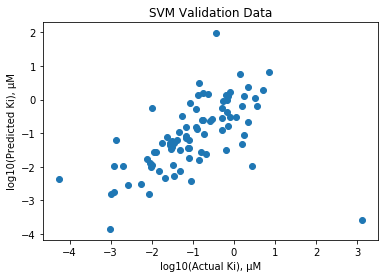

In [18]:
#Run SVM regression using SKLearn on test set. Linear regression for prediction accuracy
svmReg = make_pipeline(StandardScaler(), LinearSVR(random_state=0, tol=1e-5, C=c_param_SVR_test))
svmReg.fit(train_X, train_y)

pred = svmReg.predict(test_X)
MSE = mean_squared_error(test_y, pred)
RMSE = np.sqrt(MSE)
print("SVR RMSE:{}".format(RMSE))

plt.scatter(test_y, pred)
plt.xlabel('log10(Actual Ki), μM')
plt.ylabel('log10(Predicted Ki), μM')
plt.title('SVM Validation Data')

corr = scipy.stats.pearsonr(test_y, pred)
print(corr)

In [19]:
#SKLearn C parameter optimization
Cs = np.logspace(-6, 2, 16)
clf_full = GridSearchCV(estimator=LinearSVR(random_state=0, tol=1e-5), param_grid=dict(C=Cs), n_jobs=-1)
clf_full.fit(X_assays, y_assays_logKi) 
c_param_full = clf_full.best_estimator_.C

/Users/JacobUmans/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [20]:
c_param_full 

0.018478497974222907

In [21]:
#Run regressor (trained on full dataset)
test_compounds = np.stack(active_screening_compounds.morgan_fingerprint)

svmReg_full = make_pipeline(StandardScaler(), LinearSVR(random_state=0, tol=1e-5, C=c_param_full))
svmReg_full.fit(X_assays, y_assays_logKi)
pred_values = svmReg_full.predict(test_compounds)

In [22]:
#identify top hits
active_screening_compounds['pred_value'] = pred_values
active_screening_compounds.sort_values(by='pred_value').head(20)

,source,name,morgan_fingerprint,predictions,pred_value
10797,reframe,Nafamostat,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1.0,-4.573851
19603,broad,substance-p,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1.0,-3.270026
10749,reframe,Camostat,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1.0,-3.063672
4725,drugbank,"Sar9, Met (O2)11-Substance P","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,-2.878899
10877,broad,"[sar9,met(o2)11]-substance-p","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,-2.878899
10789,reframe,RWJ-58643,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,-2.231559
10747,reframe,Sepimostat mesilate,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,-2.119949
2513,drugbank,RWJ-56423,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,-2.051680
10791,reframe,Telaprevir,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",1.0,-2.013527
19920,broad,telaprevir,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",1.0,-2.013527


(array([  1.,   0.,   2.,   2.,  14.,  27.,  78., 104.,  76.,  61.,  71.,
         34.,  20.,   4.,   4.,   2.,   1.,   0.,   1.,   1.]),
 array([-4.57385111, -4.01866741, -3.46348372, -2.90830002, -2.35311633,
        -1.79793263, -1.24274894, -0.68756524, -0.13238154,  0.42280215,
         0.97798585,  1.53316954,  2.08835324,  2.64353694,  3.19872063,
         3.75390433,  4.30908802,  4.86427172,  5.41945542,  5.97463911,
         6.52982281]),
 <a list of 20 Patch objects>)

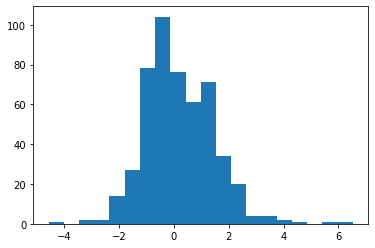

In [23]:
plt.hist(active_screening_compounds.pred_value, bins = 20)

In [24]:
i=active_screening_compounds[active_screening_compounds['name']=='Nafamostat']
i

,source,name,morgan_fingerprint,predictions,pred_value
8697,drugbank,Nafamostat,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,-1.866586
10797,reframe,Nafamostat,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1.0,-4.573851
